In [208]:
%run "../HyperParameterOpt/GenerateExperiments/res_experiment.py"
import matplotlib.pyplot as plt
import scipy.signal as sig

In [209]:
DIFF_EQ_PARAMS = {
    "x0": [-20, 10, -.5],
    "begin": 0,
    "end": 85,
    "timesteps": 85000,
    "train_per": .889,
    "solver": lorenz_equ,
    "clip": 40
}

RES_PARAMS = {
    "uniform_weights": True,
    "solver": "ridge",
    "ridge_alpha":.0001,
    "signal_dim": 3,
    "network": "random graph",
    "res_sz": 500,
    "activ_f": np.tanh,
    "connect_p": .1,
    "spect_rad": 5,
    "gamma": 5,
    "sigma": 0.05,
    "sparse_res": True,
}

def remove_edges(A, p):
    """ Randomly removes 'p' percent of edges from a sparse matrix 'A'
    """
    nedges = floor(p*np.sum(A != 0))
    A = A.todok()
    # Remove Edges
    keys = list(A.keys())
    remove_idx = np.random.choice(range(len(keys)),size=nedges, replace=False)
    remove = [keys[i] for i in remove_idx]
    for e in remove:
        A[e] = 0
    return A

In [210]:
DIFF_EQ_PARAMS["x0"] = random_lorenz_x0()
train_t, test_t, u = rc_solve_ode(DIFF_EQ_PARAMS)

In [211]:

rho = 25
mean_degree = 5
remove_p = 0.0

n = RES_PARAMS["res_sz"]
RES_PARAMS["spect_rad"] = rho
A = remove_edges(erdos(mean_degree, n), remove_p)
A = sparse.lil_matrix(A)

In [212]:
nx.is_connected(nx.Graph(A))


False

In [213]:
rc = ResComp(A, **RES_PARAMS)
rc.state_0 = 2*np.random.rand(rc.res_sz) - 1
r0 = rc.state_0
err, R = rc.fit(train_t, u, return_states=True)
U = u(test_t)
Uhat = rc.predict(test_t)
acc_dur = how_long_accurate(U, Uhat, tol=TOL) - 1
print(f"VPT: {acc_dur}")

VPT: 75


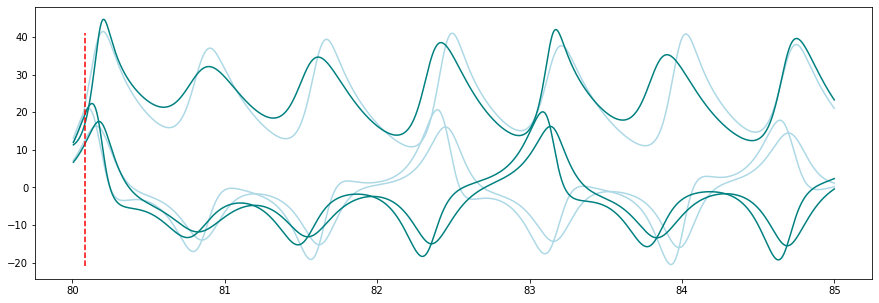

In [214]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(test_t, U.T, c="lightblue")
ax.plot(test_t, Uhat.T, c="teal")
ax.plot(test_t[acc_dur]*np.ones(20), np.linspace(-21,41, 20), "r--")


In [215]:
rho = 25
remove_p = 0.95

n = RES_PARAMS["res_sz"]
RES_PARAMS["spect_rad"] = rho
Ath = remove_edges(A, remove_p)
Ath = sparse.lil_matrix(Ath)


In [216]:
nx.is_connected(nx.Graph(Ath))


False

In [217]:

rc_th = ResComp(Ath, **RES_PARAMS)
rc_th.state_0 = 2*np.random.rand(rc_th.res_sz) - 1
r0 = rc_th.state_0
err, Rth = rc_th.fit(train_t, u, return_states=True)
Uth = u(test_t)
Uhat_th = rc_th.predict(test_t)
acc_dur_th = how_long_accurate(Uth, Uhat_th, tol=TOL) - 1
print(f"VPT: {acc_dur_th}")

VPT: 3695


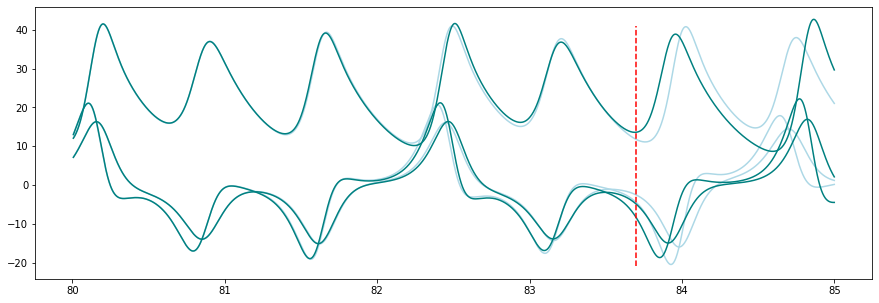

In [218]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(test_t, Uth.T, c="lightblue")
ax.plot(test_t, Uhat_th.T, c="teal")
ax.plot(test_t[acc_dur_th]*np.ones(20), np.linspace(-21,41, 20), "r--")


In [219]:
big_t = np.arange(85,385,0.01)
bigpred = rc.predict(big_t)
zcoord = bigpred[2,:]
peak_idx = sig.find_peaks(zcoord)
returns = bigpred[2,:][peak_idx[0]]


In [220]:
bigpred_th = rc_th.predict(big_t)
zcoord_th = bigpred_th[2,:]
peak_idx_th = sig.find_peaks(zcoord_th)
thinned_returns = bigpred_th[2,:][peak_idx_th[0]]


In [221]:
DIFF_EQ_PARAMS2 = {
    "x0": [-20, 10, -.5],
    "begin": 0,
    "end": 340,
    "timesteps": 340000,
    "train_per": 0.99,
    "solver": lorenz_equ,
    "clip": 40
}
bigtrain_t, bigtest_t, big_u = rc_solve_ode(DIFF_EQ_PARAMS2)
bigU = big_u(bigtrain_t)
U_zcoord = bigU[2,:]
true_peak_idx = sig.find_peaks(U_zcoord)
true_returns = U_zcoord[true_peak_idx[0]]

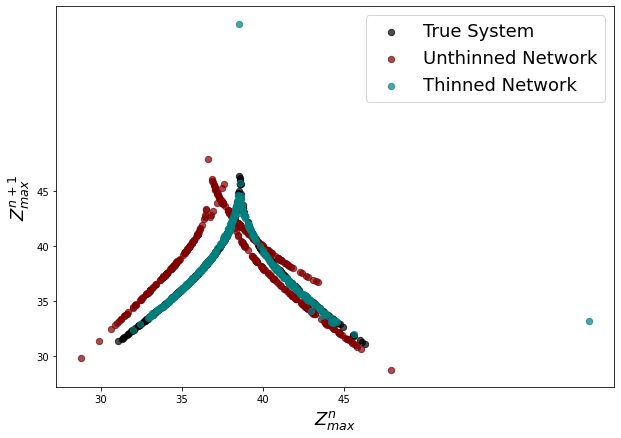

In [222]:
fig, ax = plt.subplots(1,1, figsize=(10,7))
alpha=0.7
size=40

ax.scatter(true_returns[0:-1], true_returns[1:], color="k", alpha=alpha, s=size, label="True System")
ax.scatter(returns[0:-1], returns[1:], color="maroon", alpha=alpha, s=size, label="Unthinned Network")
ax.scatter(thinned_returns[0:-1], thinned_returns[1:], color="teal", s=size, alpha=alpha, label="Thinned Network")

ax.set_xticks([30, 35, 40, 45])
ax.set_yticks([30, 35, 40, 45])
ax.set_xlabel("$Z^{n}_{max}$", fontsize=18)
ax.set_ylabel("$Z^{n+1}_{max}$", fontsize=18)

ax.legend(fontsize=18)
plt.savefig("return_map2.png", dpi=300)